In [ ]:
!pip install sklvq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import graphviz
import itertools
import numpy as np
import pandas as pd
from sklvq import GLVQ
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, make_scorer, precision_score, recall_score, roc_auc_score

In [ ]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data', names=["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


### Versão 1: sem tratamento (sem remoção de outliers)

In [ ]:
X = data.drop(["class"], axis=1).values
Y = data["class"].values

### Versão 2: com tratamento (com remoção de outliers)

In [ ]:
numeric_cols = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans',
                'fAlpha', 'fDist']
z_scores = data[numeric_cols].apply(lambda x: (x - x.mean()) / x.std())


threshold = 3
outliers = (z_scores.abs() > threshold).any(axis=1)
df_cleaned = data[~outliers]

In [ ]:
X = df_cleaned.drop(["class"], axis=1).values
Y = df_cleaned["class"].values

## Pré-processamento

In [ ]:
le = LabelEncoder()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
kf = StratifiedKFold(n_splits=10)
kf.get_n_splits(X, Y)

10

## Funções auxiliares

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## k-NN

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, train_size=0.8, random_state=42)

In [ ]:
knn = KNeighborsClassifier()
# parâmetros do gridsearch
params = {
  "n_neighbors": list(range(1, 14, 2)),
  "weights": ["uniform", "distance"],
  "metric": ["euclidean", "manhattan"]
}

# busca dos melhores parâmetros
search = GridSearchCV(knn, params)

# executa e salva os melhores parâmetros
result = search.fit(X_train, Y_train)
best_model = result.best_estimator_
Y_pred = best_model.predict(X_test)
print("Melhores parâmetros: ", result.best_params_)
print("Melhor acuracia: ", accuracy_score(Y_test, Y_pred))
print("Melhor f1-score: ", f1_score(Y_test, Y_pred, average="binary", pos_label="g"))

Melhores parâmetros:  {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Melhor acuracia:  0.8477917981072555
Melhor f1-score:  0.8907753254102999


In [ ]:
kf_accuracy = list()
kf_conf_mat = list()
kf_f1 = list()
kf_recall = list()
kf_roc = list()

In [ ]:
for train_ix, test_ix in kf.split(X_scaled, Y):
  X_train, X_test = X_scaled[train_ix, :], X_scaled[test_ix, :]
  Y_train, Y_test = Y[train_ix], Y[test_ix]

  knn = KNeighborsClassifier(n_neighbors=9, weights="distance", metric="manhattan")
  knn.fit(X_train, Y_train)
  Y_pred = knn.predict(X_test)
  Y_test_enc = le.fit_transform(Y_test)
  Y_pred_enc = le.fit_transform(Y_pred)

  # métricas
  acc = accuracy_score(Y_test, Y_pred)
  conf_mat = confusion_matrix(Y_test, Y_pred)
  f1 = f1_score(Y_test, Y_pred, average="macro")
  recall = recall_score(Y_test, Y_pred, average="macro")
  roc = roc_auc_score(Y_test_enc, Y_pred_enc, multi_class="ovo", average = "macro")

  # armazenamento de métricas
  kf_accuracy.append(acc)
  kf_conf_mat.append(conf_mat)
  kf_f1.append(f1)
  kf_recall.append(recall)
  kf_roc.append(roc)

In [ ]:
print("Accuracy: %.4f (%.4f)" % (np.mean(kf_accuracy), np.std(kf_accuracy)))
print("F1-score: %.4f (%.4f)" % (np.mean(kf_f1), np.std(kf_f1)))
print("Recall: %.4f (%.4f)" % (np.mean(kf_recall), np.std(kf_recall)))
print("AUC: %.4f (%.4f)" % (np.mean(kf_roc), np.std(kf_roc)))

Accuracy: 0.8483 (0.0065)
F1-score: 0.8200 (0.0084)
Recall: 0.8014 (0.0087)
AUC: 0.8014 (0.0087)


In [ ]:
conf_mat_mean = np.mean(kf_conf_mat, axis=0)

Confusion matrix, without normalization
[[1183.1   50.1]
 [ 238.5  430.3]]


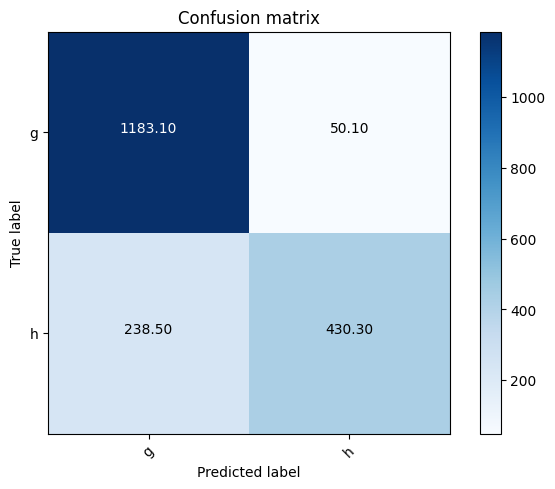

In [ ]:
plot_confusion_matrix(conf_mat_mean,["g","h"])
# plt.savefig('MC_KNN.png', transparent=True, dpi=300, bbox_inches="tight")

## LVQ

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, train_size=0.8, random_state=42)

In [ ]:
lvq = GLVQ()
# parâmetros do gridsearch
params = dict()
params = {
  "distance_type": ["squared-euclidean", "euclidean"],
  "activation_type": ["swish", "sigmoid", "soft+"]
}

# busca dos melhores parâmetros
search = GridSearchCV(lvq, params)

# executa e salva os melhores parâmetros
result = search.fit(X_train, Y_train)
best_model = result.best_estimator_
Y_pred = best_model.predict(X_test)
print("Melhores parâmetros: ", result.best_params_)
print("Melhor acuracia: ", accuracy_score(Y_test, Y_pred))
print("Melhor f1-score: ", f1_score(Y_test, Y_pred, average="binary", pos_label="g"))

Melhores parâmetros:  {'activation_type': 'swish', 'distance_type': 'squared-euclidean'}
Melhor acuracia:  0.7820715036803365
Melhor f1-score:  0.8490256783828082


In [ ]:
lvq_accuracy = list()
lvq_conf_mat = list()
lvq_f1 = list()
lvq_recall = list()
lvq_roc = list()

In [ ]:
for train_ix, test_ix in kf.split(X_scaled, Y):
  X_train, X_test = X_scaled[train_ix, :], X_scaled[test_ix, :]
  Y_train, Y_test = Y[train_ix], Y[test_ix]

  lvq = GLVQ(activation_type="swish", distance_type="squared-euclidean")
  lvq.fit(X_train, Y_train)
  Y_pred = lvq.predict(X_test)
  Y_test_enc = le.fit_transform(Y_test)
  Y_pred_enc = le.fit_transform(Y_pred)

  # métricas
  acc = accuracy_score(Y_test, Y_pred)
  conf_mat = confusion_matrix(Y_test, Y_pred)
  f1 = f1_score(Y_test, Y_pred, average="macro")
  recall = recall_score(Y_test, Y_pred, average="macro")
  roc = roc_auc_score(Y_test_enc, Y_pred_enc, multi_class="ovo", average = "macro")

  # armazenamento de métricas
  lvq_accuracy.append(acc)
  lvq_conf_mat.append(conf_mat)
  lvq_f1.append(f1)
  lvq_recall.append(recall)
  lvq_roc.append(roc)

In [ ]:
print("Accuracy: %.4f (%.4f)" % (np.mean(lvq_accuracy), np.std(lvq_accuracy)))
print("F1-score: %.4f (%.4f)" % (np.mean(lvq_f1), np.std(lvq_f1)))
print("Recall: %.4f (%.4f)" % (np.mean(lvq_recall), np.std(lvq_recall)))
print("AUC: %.4f (%.4f)" % (np.mean(lvq_roc), np.std(lvq_roc)))

Accuracy: 0.7811 (0.0085)
F1-score: 0.7312 (0.0148)
Recall: 0.7167 (0.0139)
AUC: 0.7167 (0.0139)


In [ ]:
conf_mat_mean = np.mean(lvq_conf_mat, axis=0)

Confusion matrix, without normalization
[[1151.7   81.5]
 [ 334.8  334. ]]


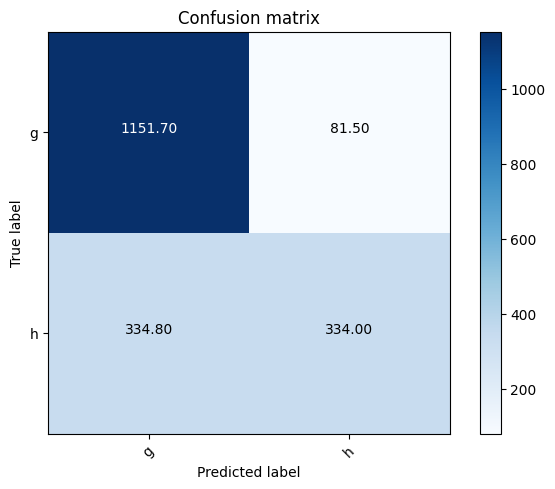

In [ ]:
plot_confusion_matrix(conf_mat_mean,["g","h"])
# plt.savefig('MC_LVQ.png', transparent=True, dpi=300, bbox_inches="tight")

###Decision Tree

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, train_size=0.8, random_state=42)

In [ ]:
dt = DecisionTreeClassifier()
# parâmetros do gridsearch
params = dict()
params = {
  "criterion": ["gini", "entropy", "log_loss"],
  "splitter": ["best", "random"]
}

# busca dos melhores parâmetros
search = GridSearchCV(dt, params)

# executa e salva os melhores parâmetros
result = search.fit(X_train, Y_train)
best_model = result.best_estimator_
Y_pred = best_model.predict(X_test)
print("Melhores parâmetros: ", result.best_params_)
print("Melhor acuracia: ", accuracy_score(Y_test, Y_pred))
print("Melhor f1-score: ", f1_score(Y_test, Y_pred, average="binary", pos_label="g"))

Melhores parâmetros:  {'criterion': 'entropy', 'splitter': 'best'}
Melhor acuracia:  0.8201892744479495
Melhor f1-score:  0.862540192926045


In [ ]:
dt_accuracy = list()
dt_conf_mat = list()
dt_f1 = list()
dt_recall = list()
dt_roc = list()

In [ ]:
for train_ix, test_ix in kf.split(X_scaled, Y):
  X_train, X_test = X_scaled[train_ix, :], X_scaled[test_ix, :]
  Y_train, Y_test = Y[train_ix], Y[test_ix]

  dt = DecisionTreeClassifier(criterion="entropy", splitter="best")
  dt.fit(X_train, Y_train)
  Y_pred = dt.predict(X_test)
  Y_test_enc = le.fit_transform(Y_test)
  Y_pred_enc = le.fit_transform(Y_pred)

  # métricas
  acc = accuracy_score(Y_test, Y_pred)
  conf_mat = confusion_matrix(Y_test, Y_pred)
  f1 = f1_score(Y_test, Y_pred, average="macro")
  recall = recall_score(Y_test, Y_pred, average="macro")
  roc = roc_auc_score(Y_test_enc, Y_pred_enc, multi_class="ovo", average = "macro")

  # armazenamento de métricas
  dt_accuracy.append(acc)
  dt_conf_mat.append(conf_mat)
  dt_f1.append(f1)
  dt_recall.append(recall)
  dt_roc.append(roc)

In [ ]:
names = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']

dot_data = export_graphviz(dt, out_file=None, feature_names=names[:-1], class_names=['g', 'h'], filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render("decision_tree")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.469946 to fit


'decision_tree.png'

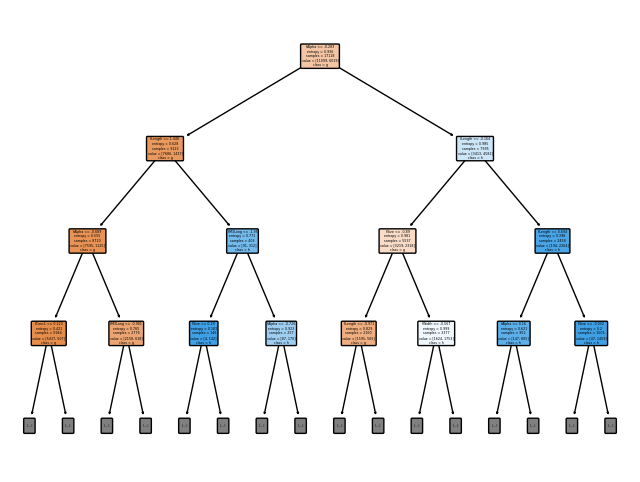

In [ ]:
plt.figure(figsize=(8, 6))
plot_tree(dt, feature_names=names[:-1], class_names=['g', 'h'], filled=True, rounded=True, max_depth=3)
plt.show()

In [ ]:
print("Accuracy: %.4f (%.4f)" % (np.mean(dt_accuracy), np.std(dt_accuracy)))
print("F1-score: %.4f (%.4f)" % (np.mean(dt_f1), np.std(dt_f1)))
print("Recall: %.4f (%.4f)" % (np.mean(dt_recall), np.std(dt_recall)))
print("AUC: %.4f (%.4f)" % (np.mean(dt_roc), np.std(dt_roc)))

Accuracy: 0.8218 (0.0097)
F1-score: 0.8042 (0.0114)
Recall: 0.8036 (0.0127)
AUC: 0.8036 (0.0127)


In [ ]:
conf_mat_mean = np.mean(dt_conf_mat, axis=0)

Confusion matrix, without normalization
[[1066.6  166.6]
 [ 172.3  496.5]]


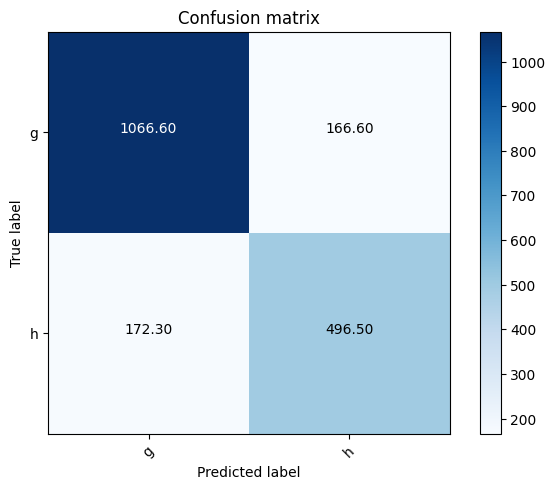

In [ ]:
plot_confusion_matrix(conf_mat_mean,["g","h"])
# plt.savefig('MC_DT.png', transparent=True, dpi=300, bbox_inches="tight")

## Random forest

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, train_size=0.8, random_state=42)

In [ ]:
rf = RandomForestClassifier()
# parâmetros do gridsearch
params = {
  "criterion": ["gini", "entropy", "log_loss"]
}

# busca dos melhores parâmetros
search = GridSearchCV(rf, params)

# executa e salva os melhores parâmetros
result = search.fit(X_train, Y_train)
best_model = result.best_estimator_
Y_pred = best_model.predict(X_test)
print("Melhores parâmetros: ", result.best_params_)
print("Melhor acurácia: ", accuracy_score(Y_test, Y_pred))
print("Melhor f1-score: ", f1_score(Y_test, Y_pred, average="binary", pos_label="g"))

Melhores parâmetros:  {'criterion': 'entropy'}
Melhor acurácia:  0.8809148264984227
Melhor f1-score:  0.9112634671890304


In [ ]:
rf_accuracy = list()
rf_conf_mat = list()
rf_f1 = list()
rf_recall = list()
rf_roc = list()

In [ ]:
for train_ix, test_ix in kf.split(X_scaled, Y):
  X_train, X_test = X_scaled[train_ix, :], X_scaled[test_ix, :]
  Y_train, Y_test = Y[train_ix], Y[test_ix]

  rf = RandomForestClassifier(criterion="entropy")
  rf.fit(X_train, Y_train)
  Y_pred = rf.predict(X_test)
  Y_test_enc = le.fit_transform(Y_test)
  Y_pred_enc = le.fit_transform(Y_pred)

  # métricas
  acc = accuracy_score(Y_test, Y_pred)
  conf_mat = confusion_matrix(Y_test, Y_pred)
  f1 = f1_score(Y_test, Y_pred, average="macro")
  recall = recall_score(Y_test, Y_pred, average="macro")
  roc = roc_auc_score(Y_test_enc, Y_pred_enc, multi_class="ovo", average = "macro")

  # armazenamento de métricas
  rf_accuracy.append(acc)
  rf_conf_mat.append(conf_mat)
  rf_f1.append(f1)
  rf_recall.append(recall)
  rf_roc.append(roc)

In [ ]:
print("Accuracy: %.4f (%.4f)" % (np.mean(rf_accuracy), np.std(rf_accuracy)))
print("F1-score: %.4f (%.4f)" % (np.mean(rf_f1), np.std(rf_f1)))
print("Recall: %.4f (%.4f)" % (np.mean(rf_recall), np.std(rf_recall)))
print("AUC: %.4f (%.4f)" % (np.mean(rf_roc), np.std(rf_roc)))

Accuracy: 0.8820 (0.0061)
F1-score: 0.8662 (0.0069)
Recall: 0.8553 (0.0072)
AUC: 0.8553 (0.0072)


In [ ]:
conf_mat_mean_rf = np.mean(rf_conf_mat, axis=0)

Confusion matrix, without normalization
[[1165.9   67.3]
 [ 157.1  511.7]]


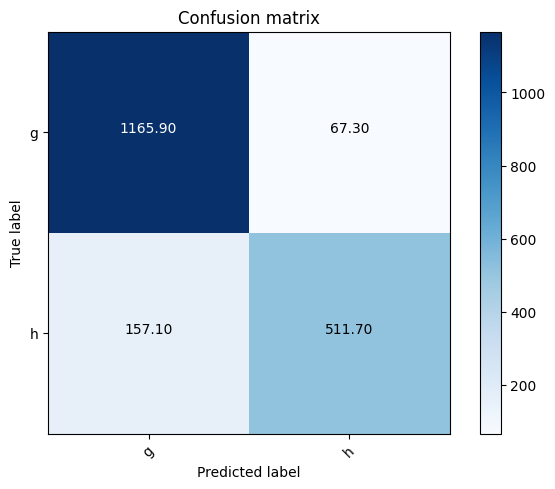

In [ ]:
plot_confusion_matrix(conf_mat_mean_rf, ["g","h"])

## MLP

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, train_size=0.8, random_state=42)

In [ ]:
mlp = MLPClassifier(max_iter=1000)
# parâmetros do gridsearch
params = {
  "hidden_layer_sizes": [(20,), (50,), (100,)],
  "activation": ["identity", "relu"]
}

# busca dos melhores parâmetros
search = GridSearchCV(mlp, params)

# executa e salva os melhores parâmetros
result = search.fit(X_train, Y_train)
best_model = result.best_estimator_
Y_pred = best_model.predict(X_test)
print("Melhores parâmetros: ", result.best_params_)
print("Melhor acurácia: ", accuracy_score(Y_test, Y_pred))
print("Melhor f1-score: ", f1_score(Y_test, Y_pred, average="binary", pos_label="g"))

Melhores parâmetros:  {'activation': 'relu', 'hidden_layer_sizes': (100,)}
Melhor acurácia:  0.8751314405888538
Melhor f1-score:  0.9074254531280451


In [ ]:
mlp_accuracy = list()
mlp_conf_mat = list()
mlp_f1 = list()
mlp_recall = list()
mlp_roc = list()

In [ ]:
for train_ix, test_ix in kf.split(X_scaled, Y):
  X_train, X_test = X_scaled[train_ix, :], X_scaled[test_ix, :]
  Y_train, Y_test = Y[train_ix], Y[test_ix]

  mlp = MLPClassifier(max_iter=1000, hidden_layer_sizes=(100,), activation="relu")
  mlp.fit(X_train, Y_train)
  Y_pred = mlp.predict(X_test)
  Y_test_enc = le.fit_transform(Y_test)
  Y_pred_enc = le.fit_transform(Y_pred)

  # métricas
  acc = accuracy_score(Y_test, Y_pred)
  conf_mat = confusion_matrix(Y_test, Y_pred)
  f1 = f1_score(Y_test, Y_pred, average="macro")
  recall = recall_score(Y_test, Y_pred, average="macro")
  roc = roc_auc_score(Y_test_enc, Y_pred_enc, multi_class="ovo", average = "macro")

  # armazenamento de métricas
  mlp_accuracy.append(acc)
  mlp_conf_mat.append(conf_mat)
  mlp_f1.append(f1)
  mlp_recall.append(recall)
  mlp_roc.append(roc)

In [ ]:
print("Accuracy: %.4f (%.4f)" % (np.mean(mlp_accuracy), np.std(mlp_accuracy)))
print("F1-score: %.4f (%.4f)" % (np.mean(mlp_f1), np.std(mlp_f1)))
print("Recall: %.4f (%.4f)" % (np.mean(mlp_recall), np.std(mlp_recall)))
print("AUC: %.4f (%.4f)" % (np.mean(mlp_roc), np.std(mlp_roc)))

Accuracy: 0.8773 (0.0058)
F1-score: 0.8607 (0.0070)
Recall: 0.8498 (0.0082)
AUC: 0.8498 (0.0082)


In [ ]:
conf_mat_mean_mlp = np.mean(mlp_conf_mat, axis=0)

Confusion matrix, without normalization
[[1162.5   70.7]
 [ 162.6  506.2]]


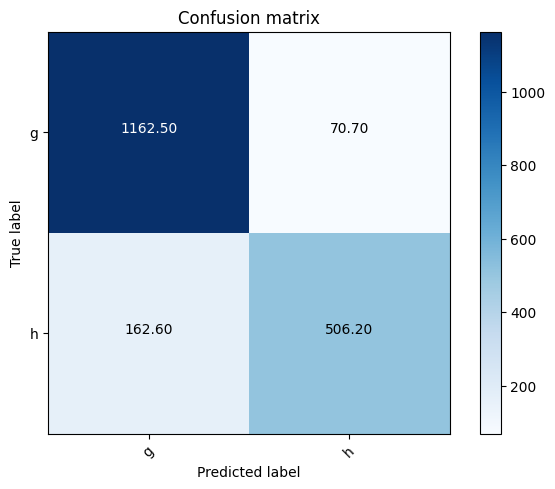

In [ ]:
plot_confusion_matrix(conf_mat_mean_mlp, ["g","h"])

###SVM

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, train_size=0.8, random_state=42)

In [ ]:
svm = SVC(max_iter=1000)
# parâmetros do gridsearch
params = {
      "C": [0.1,1,5],
      "gamma": ["scale", "auto"],
      "kernel": ["poly", "rbf", "sigmoid"]
      }

# busca dos melhores parâmetros
search = GridSearchCV(svm, params)

# executa e salva os melhores parâmetros
result = search.fit(X_train, Y_train)
best_model = result.best_estimator_
Y_pred = best_model.predict(X_test)
print("Melhores parâmetros: ", result.best_params_)
print("Melhor f1-score: ", f1_score(Y_test, Y_pred, average="binary", pos_label="g"))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider

Melhores parâmetros:  {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Melhor f1-score:  0.6410488245931284


In [ ]:
svm_accuracy = list()
svm_conf_mat = list()
svm_f1 = list()
svm_recall = list()
svm_roc = list()

In [ ]:
for train_ix, test_ix in kf.split(X_scaled, Y):
  X_train, X_test = X_scaled[train_ix, :], X_scaled[test_ix, :]
  Y_train, Y_test = Y[train_ix], Y[test_ix]

  svm = SVC(max_iter=1000, C=1, gamma="auto", kernel="rbf")
  svm.fit(X_train, Y_train)
  Y_pred = svm.predict(X_test)
  Y_test_enc = le.fit_transform(Y_test)
  Y_pred_enc = le.fit_transform(Y_pred)

  # métricas
  acc = accuracy_score(Y_test, Y_pred)
  conf_mat = confusion_matrix(Y_test, Y_pred)
  f1 = f1_score(Y_test, Y_pred, average="macro")
  recall = recall_score(Y_test, Y_pred, average="macro")
  roc = roc_auc_score(Y_test_enc, Y_pred_enc, multi_class="ovo", average = "macro")

  # armazenamento de métricas
  svm_accuracy.append(acc)
  svm_conf_mat.append(conf_mat)
  svm_f1.append(f1)
  svm_recall.append(recall)
  svm_roc.append(roc)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider

In [ ]:
print("Accuracy: %.4f (%.4f)" % (np.mean(svm_accuracy), np.std(svm_accuracy)))
print("F1-score: %.4f (%.4f)" % (np.mean(svm_f1), np.std(svm_f1)))
print("Recall: %.4f (%.4f)" % (np.mean(svm_recall), np.std(svm_recall)))
print("AUC: %.4f (%.4f)" % (np.mean(svm_roc), np.std(svm_roc)))

Accuracy: 0.6332 (0.0705)
F1-score: 0.6134 (0.0593)
Recall: 0.6261 (0.0467)
AUC: 0.6261 (0.0467)


In [ ]:
conf_mat_mean = np.mean(svm_conf_mat, axis=0)

Confusion matrix, without normalization
[[801.6 431.6]
 [266.1 402.7]]


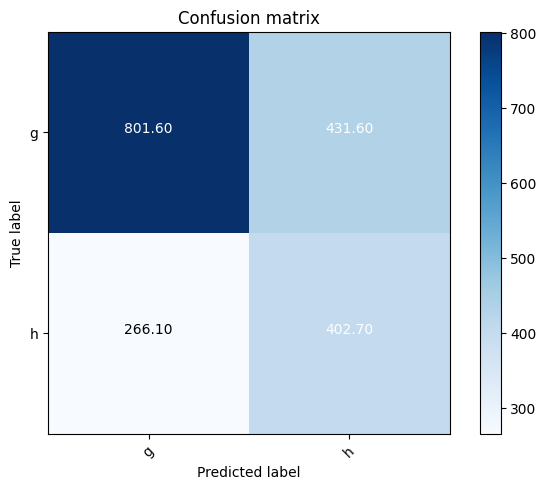

In [ ]:
plot_confusion_matrix(conf_mat_mean,["g","h"])
# plt.savefig('MC_SVM.png', transparent=True, dpi=300, bbox_inches="tight")

## Ensemble

In [ ]:
# Voting Ensemble for Classification
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
import warnings
warnings.filterwarnings("ignore")

seed = 5
kfold = model_selection.StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)

# create the sub models
estimators = []

model1 = KNeighborsClassifier(n_neighbors=9, weights="distance", metric="manhattan")
estimators.append(('knn', model1))

model2 = GLVQ(activation_type="swish", distance_type="squared-euclidean")
estimators.append(('lvq', model2))

model3 = DecisionTreeClassifier(criterion="entropy", splitter="best")
estimators.append(('dt', model3))

model4 = RandomForestClassifier(criterion="entropy")
estimators.append(('rf', model4))

model5 = MLPClassifier(max_iter=1000, hidden_layer_sizes=(100,), activation="relu")
estimators.append(('mlp', model5))

model6 = SVC(max_iter=1000, C=1, gamma="auto", kernel="rbf")
estimators.append(('svm', model6))

#train

# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X, Y, cv=kfold)
print(results.mean())
print(results.std())
print('Media clf ', results.mean(), 'Desvio ', results.std(), 'Media ', results.mean(), 'Desvio ', results.std())

0.8334384858044164
0.009280264085687901
Media clf  0.8334384858044164 Desvio  0.009280264085687901 Media Bagging 0.8334384858044164 Desvio  0.009280264085687901


>knn 0.821 (0.006)
>lvq 0.708 (0.013)
>dt 0.822 (0.009)
>rf 0.881 (0.007)
>mlp 0.840 (0.015)
>svm 0.634 (0.010)
>stacking 0.882 (0.008)


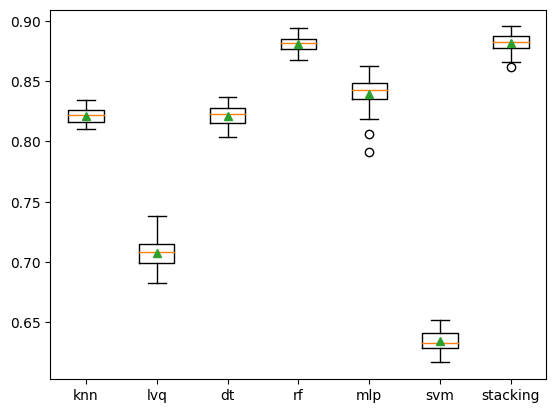

In [ ]:
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot


#get a stacking ensemble of models
def get_stacking():
  # define the base models
	level0 = list()
	level0.append(('knn', KNeighborsClassifier(n_neighbors=9, weights="distance", metric="manhattan")))
	level0.append(('lvq', GLVQ(activation_type="swish", distance_type="squared-euclidean")))
	level0.append(('dt', DecisionTreeClassifier(criterion="log_loss", splitter="best")))
	level0.append(('rf', RandomForestClassifier(criterion="log_loss")))
	level0.append(('mlp', MLPClassifier(max_iter=1000, hidden_layer_sizes=(100,), activation="relu")))
  #level0.append(('svm', SVC(max_iter=1000, C=1, gamma="auto", kernel="rbf")))
  # define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model


# get a list of models to evaluate
def get_models():
	models = dict()
	models['knn'] = KNeighborsClassifier(n_neighbors=9, weights="distance", metric="manhattan")
	models['lvq'] = GLVQ(activation_type="swish", distance_type="squared-euclidean")
	models['dt'] = DecisionTreeClassifier(criterion="log_loss", splitter="best")
	models['rf'] = RandomForestClassifier(criterion="log_loss")
	models['mlp'] = MLPClassifier(max_iter=1000, hidden_layer_sizes=(100,), activation="relu")
	models['svm'] = SVC(max_iter=1000, C=1, gamma="auto", kernel="rbf")
	models['stacking'] = get_stacking()
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, Y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, Y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()